# constrActive optimization

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import scipy as sp
from eden.util import configure_logging
import logging
configure_logging(logging.getLogger(),verbosity=1)

from IPython.core.display import HTML
HTML('<style>.container { width:95% !important; }</style><style>.output_png {display: table-cell;text-align: center;vertical-align: middle;}</style>')

# Todo

Extract pareto front on 1) score, 2) similarity 3) size

then discretize similarity of paret set in k bins and run pareto front again to have only k results

# Set up input graphs

In [2]:
from toolz import curry, pipe
from eden_chem.io.pubchem import download
from eden_chem.obabel import load as babel_load

download_active = curry(download)(active=True)
download_inactive = curry(download)(active=False)

def get_pos_graphs(assay_id): return pipe(assay_id, download_active, babel_load, list)
def get_neg_graphs(assay_id): return pipe(assay_id, download_inactive, babel_load, list)

In [3]:
from sklearn.neighbors import NearestNeighbors
from eden.graph import Vectorizer
import random
from constrActive import min_similarity_selection
from sklearn.metrics.pairwise import cosine_similarity

def outliers(graphs, k=3):
    vec = Vectorizer(r=3, d=3, normalization=False, inner_normalization=False, n_jobs=1)
    x = vec.transform(graphs)
    knn = NearestNeighbors()
    knn.fit(x)
    neigbhbors = knn.kneighbors(x, n_neighbors=k, return_distance=False)
    outlier_list = []
    non_outlier_list = []
    for i,ns in enumerate(neigbhbors):
        not_outlier = False
        for n in ns[1:]:
            if i in list(neigbhbors[n,:]):
                not_outlier=True
                break
        if not_outlier is False:
            outlier_list.append(i)
        else:
            non_outlier_list.append(i)
    return outlier_list, non_outlier_list

def select_non_outliers(graphs, k=3):
    outlier_list, non_outlier_list = outliers(graphs, k)
    graphs = [graphs[i] for i in non_outlier_list]
    logging.info('outlier removal:%d'%len(graphs))
    return graphs

def remove_similar_pairs(graphs):
    vec = Vectorizer(r=3, d=3, normalization=False, inner_normalization=False, n_jobs=1)
    x = vec.transform(graphs)
    matrix = cosine_similarity(x)
    scores = np.array([1]*len(graphs))
    ids = min_similarity_selection(matrix, scores=scores, max_num=len(graphs)/2)
    graphs = [graphs[i] for i in ids]
    logging.info('similar pairs removal:%d'%len(graphs))
    return graphs
    
def size_filter(graphs, fraction_to_remove=.1):
    frac = 1.0 - fraction_to_remove/2
    size = len(graphs)
    graphs = sorted(graphs, key=lambda g:len(g))[:int(size*frac)]
    graphs = sorted(graphs, key=lambda g:len(g), reverse=True)[:int(size*frac)]
    logging.info('size filter:%d'%len(graphs))
    return graphs

def random_sample(graphs, max_size):
    if len(graphs) > max_size:
        graphs = random.sample(graphs, max_size)
    logging.info('random sample:%d'%len(graphs))
    return graphs
    
def pre_process(graphs, fraction_to_remove=.1, n_neighbors_for_outliers=3, max_size=500):
    logging.info('original size:%d'% len(graphs))
    graphs = random_sample(graphs, 3000)
    graphs = size_filter(graphs, fraction_to_remove)
    graphs = select_non_outliers(graphs, k=n_neighbors_for_outliers)
    graphs = remove_similar_pairs(graphs)
    graphs = random_sample(graphs, max_size)
    return graphs

In [4]:
def display(pareto_set_graphs, references_graphs, predictor, draw_params):
    predictor.n_jobs=1
    logging.info('Seeds:')
    preds = predictor.decision_function(references_graphs)
    logging.info('Estimated scores:')
    msg=''
    for i,p in enumerate(preds): msg += '%2d) %.2f   '%(i,p)
    logging.info(msg)
    draw.graphlearn(references_graphs, **draw_params)

    logging.info('Result:')
    preds = predictor.decision_function(pareto_set_graphs)
    logging.info('Estimated scores:')
    msg=''
    for i,p in enumerate(preds): msg += '%2d) %.2f   '%(i,p)
    logging.info(msg)
    draw.graphlearn(pareto_set_graphs, **draw_params)

# Experiment

In [5]:
assay_id = '651610' #apr93 23k mols
assay_id = '1834'   #apr90 500 mols
assay_id = '624466' #apr88 p5k n23k
assay_id = '588350' #apr86 p1k n600
assay_id = '449764' #apr85
assay_id = '492952' #apr85
assay_id = '463112' #apr82
assay_id = '463213' #apr70
assay_id = '119'    #apr60 30k mols
assay_id = '1224857'#apr10
assay_id = '2326'   #apr03 200k mols

#-------------------------------------------------
# choose

assay_id = '588350' #apr86 p1k n600
assay_id = '624466' #apr88 p5k n23k
assay_id = '651610' #apr93 23k mols

In [6]:
# extract pos and neg graphs
all_pos_graphs, all_neg_graphs = get_pos_graphs(assay_id), get_neg_graphs(assay_id)

In [7]:
%%time
# induce the oracle on the whole dataset
from eden.estimator import EdenEstimator
y = [1] * len(all_pos_graphs) + [-1] * len(all_neg_graphs)
predictor = EdenEstimator(r=3, d=6, normalization=True, inner_normalization=True)
scores = predictor.cross_val_score(all_pos_graphs+all_neg_graphs, y)
logging.info('AUC ROC: %.2f +-%.2f' % (np.mean(scores), np.std(scores)))
predictor.fit(all_pos_graphs+all_neg_graphs, y)

AUC ROC: 0.82 +-0.13
CPU times: user 2min 29s, sys: 47.1 s, total: 3min 16s
Wall time: 2min 58s


In [8]:
%%time
# remove too large and too small graphs and outliers
args=dict(fraction_to_remove=.2, n_neighbors_for_outliers=3, max_size=500)
pos_graphs, neg_graphs = pre_process(all_pos_graphs, **args), pre_process(all_neg_graphs, **args)

# setup colors
from eden.display import map_labels_to_colors
label_colors = map_labels_to_colors(all_pos_graphs + all_neg_graphs)
from graphlearn.utils import draw
draw_params = dict(n_graphs_per_line=7, size=9, colormap='Paired', vertex_color='_labels_', vertex_color_dict=label_colors, vertex_alpha=0.5, edge_alpha=0.2)

original size:3866
random sample:3000
size filter:2700
outlier removal:1628
similar pairs removal:814
random sample:500
original size:22949
random sample:3000
size filter:2700
outlier removal:2231
similar pairs removal:1115
random sample:500
CPU times: user 1min 9s, sys: 0 ns, total: 1min 9s
Wall time: 1min 6s


Top scoring
2.38    2.25    2.25    2.17    2.15    2.14    2.14   

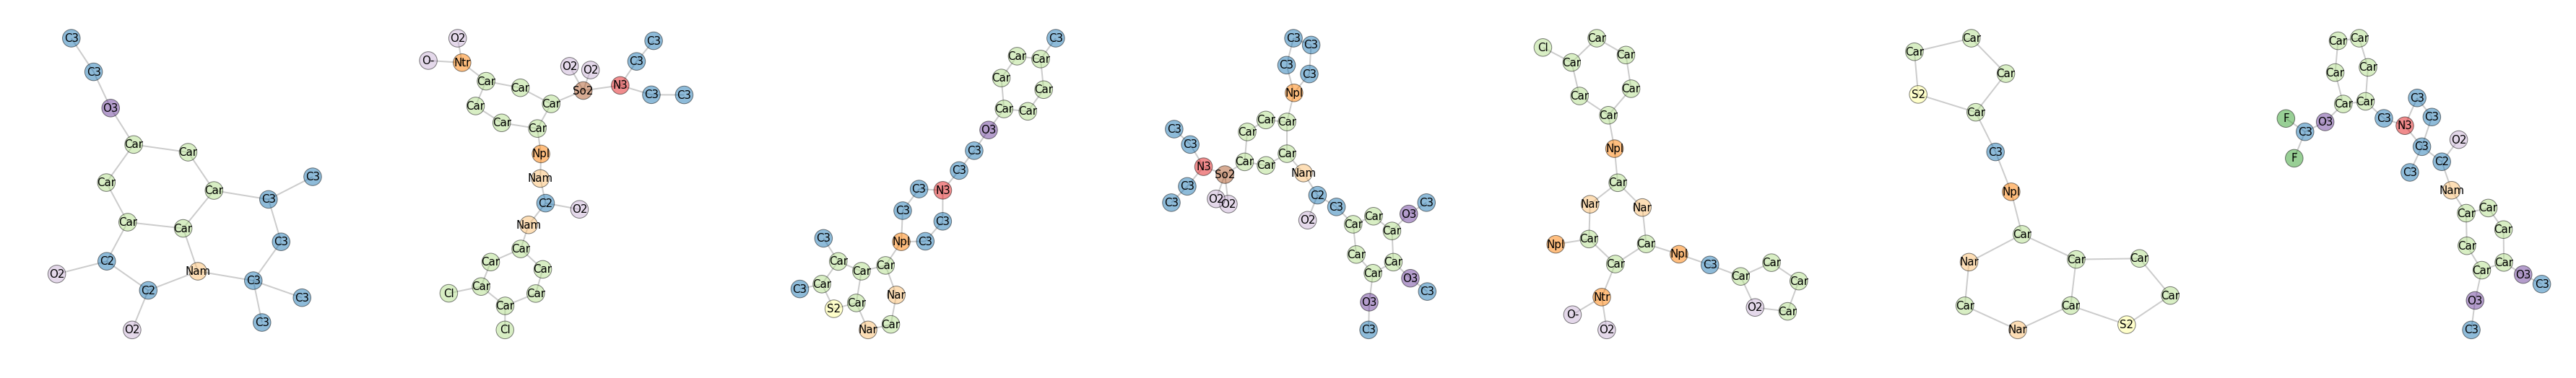

Process PoolWorker-380:
Process PoolWorker-394:
Process PoolWorker-382:
Process PoolWorker-391:
Process PoolWorker-385:
Process PoolWorker-389:
Process PoolWorker-369:
Process PoolWorker-384:
Process PoolWorker-375:


KeyboardInterrupt: 

Process PoolWorker-370:
Process PoolWorker-396:
Process PoolWorker-387:
Process PoolWorker-392:
Process PoolWorker-378:
Process PoolWorker-373:
Process PoolWorker-388:
Exception KeyboardInterrupt in 'zmq.backend.cython.message.Frame.__dealloc__' ignored
Process PoolWorker-381:
Process PoolWorker-363:
Process PoolWorker-393:
Process PoolWorker-362:
Process PoolWorker-377:
Process PoolWorker-372:
Process PoolWorker-395:
Process PoolWorker-374:
Process PoolWorker-383:
Process PoolWorker-365:
Process PoolWorker-386:
Process PoolWorker-390:
Process PoolWorker-376:
Process PoolWorker-361:
Process PoolWorker-366:
Process PoolWorker-367:
Process PoolWorker-364:
Process PoolWorker-371:
Process PoolWorker-379:
Process PoolWorker-368:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recen

    self._target(*self._args, **self._kwargs)
  File "/home/fc334/miniconda2/envs/eden_env/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/home/fc334/miniconda2/envs/eden_env/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self._target(*self._args, **self._kwargs)
    self._target(*self._args, **self._kwargs)
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
    self._target(*self._args, **self._kwargs)
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
Traceback (most recent call last):
    self._target(*self._args, **self._kwargs)
    self._target(*self._args, **self._kwargs)
    self._target(*self._args, **self._kwargs)
    self._target(*self._args, **self._kwargs)
    self._target(*self._args, **self._kwargs)
  File "/home/fc334/miniconda2/envs/eden_env/lib/python2.7/multiprocessing/process.py", line 114, in run
Traceback (most recent call last):
    self._target(*self._a

    task = get()
  File "/home/fc334/miniconda2/envs/eden_env/lib/python2.7/multiprocessing/queues.py", line 376, in get
  File "/home/fc334/miniconda2/envs/eden_env/lib/python2.7/multiprocessing/process.py", line 114, in run
    task = get()
  File "/home/fc334/miniconda2/envs/eden_env/lib/python2.7/multiprocessing/queues.py", line 376, in get
  File "/home/fc334/miniconda2/envs/eden_env/lib/python2.7/multiprocessing/queues.py", line 376, in get
    task = get()
  File "/home/fc334/miniconda2/envs/eden_env/lib/python2.7/multiprocessing/queues.py", line 376, in get
  File "/home/fc334/miniconda2/envs/eden_env/lib/python2.7/multiprocessing/queues.py", line 376, in get
  File "/home/fc334/miniconda2/envs/eden_env/lib/python2.7/multiprocessing/pool.py", line 102, in worker
  File "/home/fc334/miniconda2/envs/eden_env/lib/python2.7/multiprocessing/queues.py", line 376, in get
    racquire()
  File "/home/fc334/miniconda2/envs/eden_env/lib/python2.7/multiprocessing/queues.py", line 376, in 

In [12]:
%%time
scores = predictor.decision_function(pos_graphs)
print('Top scoring')
top_graphs=[]
for score, graph in sorted(zip(scores,pos_graphs), reverse=True)[:7]: 
    top_graphs.append(graph)
    print('%.2f   '%score),
draw.graphlearn(top_graphs, **draw_params)

vec = Vectorizer(r=3, d=3, normalization=True, inner_normalization=True, n_jobs=1)
x = vec.transform(pos_graphs)
matrix = cosine_similarity(x)
sim = np.mean(matrix, axis=1).reshape(-1,1)
y=1/scores
y=y.reshape(-1,1)
costs = np.hstack([y, sim])
from pareto_graph_optimizer import get_pareto_set
pareto_set_graphs = get_pareto_set(pos_graphs, costs)
pareto_set_scores = predictor.decision_function(pareto_set_graphs)
print('Pareto set of positive graphs on score and similarity [%d]'%len(pareto_set_graphs))
for i,v in enumerate(pareto_set_scores): print('%d) %.2f   '%(i,v)),
draw.graphlearn(pareto_set_graphs, **draw_params)

In [ ]:
from constrActive import optimize
args = dict(n_seeds=7, n_neighbors=9, min_count=2, return_references=True)

In [ ]:
%%time
impr_pareto_set_graphs, impr_references_graphs = optimize(pos_graphs, neg_graphs, improve=True, **args)
display(impr_pareto_set_graphs, impr_references_graphs, predictor, draw_params)

In [ ]:
%%time
pareto_set_graphs, references_graphs = optimize(pos_graphs, neg_graphs, improve=False, **args)
display(pareto_set_graphs, references_graphs, predictor, draw_params)

---